In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import random

%matplotlib inline


- objects count not correlated with area (objects/background) [TODO]
- randomized shapes? [TODO]
- randomized placement
- no overlaps
- what else?
- random color for objects


In [2]:


class GenerateImagesWithObjects:
    def __init__(self, 
                 obj_count_range=range(1, 100),
                 obj_size_range=(5, 15),
                 obj_distance_range=(5,20),
                 distribiuton='uniform',
                 image_shape=(400, 400, 3),
                 edge_dist=20,  
                 background='noise', 
                 black_and_white=False
                ):
        
        self.obj_count_range = obj_count_range
        self.obj_size_range = obj_size_range
        self.obj_distance_range = obj_distance_range
        self.distribiuton = distribiuton
        self.image_shape = image_shape
        self.edge_dist = edge_dist
        self.background = background
        self.black_and_white = black_and_white
        self.color_shape = 3
        if self.black_and_white:
            self.image_shape=self.image_shape[:2]
            self.color_shape = 1
            
        
    @staticmethod    
    def _circles_are_overlapping(circle1, circle2):
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        if circle1 == circle2:
            return True
        return abs(r0-r1)^2 <= ((x0-x1)^2 + (y0-y1)^2 <= (r0 + r1)^2)
    
    def _random_color(self):
        return np.random.randint(20, 220, size=(self.color_shape))


    def _circles_are_distant(self, circle1, circle2):  
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        dst = distance.euclidean((x0,y0),(x1,y1)) - (r0 + r1)
        return dst>np.random.randint(*self.obj_distance_range)
    
    
    def _can_place_circle(self, circles_drawn, new_circle):
        return all([self._circles_are_distant(new_circle, c_on_canvas) for c_on_canvas in circles_drawn])
    
    
    
    def _get_random_circle(self):
        if self.distribiuton == 'uniform':
            x = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            y = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            r = np.random.randint(*self.obj_size_range) 
            
        return x,y,r
    
    
    def _get_canvas(self):    
        if self.background == 'noise':
            canvas = np.random.randint(1, 255, size=self.image_shape, dtype='uint8')
        elif self.background == 'white':
            canvas = np.zeros(self.image_shape[0], dtype='uint8')
        return canvas
    
                    
    def generate_image(self, nr_objects):
        canvas = self._get_canvas()

        circles_drawn = []
        while len(circles_drawn) < nr_objects:
            x,y,r = self._get_random_circle()
            random_color = self._random_color()
            if not self._can_place_circle(circles_drawn, (x,y,r)):
                continue
            else:
                cv2.circle(canvas, (x,y), r, random_color, -1)
                circles_drawn.append((x,y,r))
        return canvas
    
    
    def _generate_batch_of_images(self, batch_size=32):
        batch = []
        for _ in range(batch_size):
            target_y = random.randint(nr_of_objecs_range)
            batch.append(self.generate_image)
        
        return np.concatenate(batch)
    
    
    def image_generator(self, nr_of_objecs_range=range(1,50), batch_size=32):
        while True:
            batch = []
            ys = []
            for _ in range(batch_size):
                target_y = random.randint(nr_of_objecs_range[0], nr_of_objecs_range[-1])
                batch.append(np.expand_dims(self.generate_image(target_y), 0))
                ys.append(target_y)
            yield (np.concatenate(batch), np.array(ys).reshape(-1, 1))
        
    
    

                
                

In [6]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
K.set_image_dim_ordering('tf')

def create_model(img_rows=400, img_cols=400):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(img_rows, img_cols, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(346))
    model.add(Activation('relu'))
    model.add(Dense(221))
    model.add(Activation('relu'))
    model.add(Dense(1))

    return model

In [7]:
model = create_model()
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_squared_error']
)


In [9]:
go = GenerateImagesWithObjects()

model.fit_generator(go.image_generator(), 500, nb_epoch=30)

Epoch 1/30
512/500 [==============================] - 14s - loss: 204.6815 - mean_squared_error: 204.6815    
Epoch 2/30
512/500 [==============================] - 13s - loss: 210.3412 - mean_squared_error: 210.3412    
Epoch 3/30
512/500 [==============================] - 13s - loss: 213.7910 - mean_squared_error: 213.7910    
Epoch 4/30
512/500 [==============================] - 13s - loss: 199.0082 - mean_squared_error: 199.0082    
Epoch 5/30
512/500 [==============================] - 13s - loss: 200.6751 - mean_squared_error: 200.6751    
Epoch 6/30
512/500 [==============================] - 13s - loss: 104.6477 - mean_squared_error: 104.6477    
Epoch 7/30
512/500 [==============================] - 13s - loss: 35.4393 - mean_squared_error: 35.4393    
Epoch 8/30
512/500 [==============================] - 13s - loss: 29.1784 - mean_squared_error: 29.1784    
Epoch 9/30
512/500 [==============================] - 13s - loss: 22.7970 - mean_squared_error: 22.7970    
Epoch 10/30
512/

KeyboardInterrupt: 

In [11]:
img = go.image_generator()

In [13]:
x, y = img.next()

In [14]:
model.predict_on_batch(x)

array([[  8.95811749],
       [ 27.51533127],
       [ 42.24740601],
       [ 32.43383408],
       [ 18.11746788],
       [ 40.98734283],
       [ 20.63640213],
       [ 39.35128784],
       [ 25.89068985],
       [ 35.98088455],
       [ 34.57218933],
       [ 22.56532669],
       [ 36.47963333],
       [  4.59673309],
       [ 36.85535431],
       [ 37.5646553 ],
       [ 42.64318848],
       [  2.17736363],
       [ 14.73463154],
       [ 41.3204422 ],
       [ 41.97187805],
       [ 38.39922714],
       [ 42.15037918],
       [ 32.04197311],
       [ 22.8342495 ],
       [ 43.91092682],
       [ 27.19886017],
       [  6.06344748],
       [ 27.98939514],
       [ 19.92999077],
       [ 24.00141335],
       [  4.33354521]], dtype=float32)

array([[ 9],
       [24],
       [39],
       [31],
       [17],
       [34],
       [21],
       [39],
       [24],
       [35],
       [30],
       [24],
       [39],
       [ 3],
       [36],
       [39],
       [42],
       [ 2],
       [12],
       [44],
       [44],
       [38],
       [48],
       [35],
       [23],
       [48],
       [33],
       [ 6],
       [26],
       [15],
       [24],
       [ 4]])

In [28]:
im = cv2.imread('NucleiDAPIconfocal.png')
from imutils import resize


# im = resize(im, width=400, height=400)
# model.predict(np.expand_dims(im, 0))

In [27]:
im.shape

(414, 400, 3)

In [33]:
resize(im, height=400).shape

(400, 386, 3)

In [35]:
def load_img(path, grayscale=False, target_size=None):
    """
    Load an image into PIL format.
    # Arguments
    path: path to image file
    grayscale: boolean
    target_size: None (default to original size)
    or (img_height, img_width)
    """

    img = Image.open(path)
    if grayscale:
        img = img.convert('L')
    else:  # Ensure 3 channel even when loaded image is grayscale
        img = img.convert('RGB')
    if target_size:
        img = img.resize((target_size[1], target_size[0]))
    return img


from PIL import Image


In [56]:
im = load_img('circles.jpg')
im = im.resize((400, 400))
im.__dict__

{'category': 0,
 'im': <ImagingCore at 0x7feef931a290>,
 'info': {'dpi': (72, 72),
  'jfif': 257,
  'jfif_density': (72, 72),
  'jfif_unit': 1,
  'jfif_version': (1, 1),
  'progression': 1,
  'progressive': 1},
 'mode': 'RGB',
 'palette': None,
 'pyaccess': None,
 'readonly': 0,
 'size': (400, 400)}

In [55]:
im2 = np.asarray(im)
model.predict(np.expand_dims(im2,0))

array([[ 186.47502136]], dtype=float32)

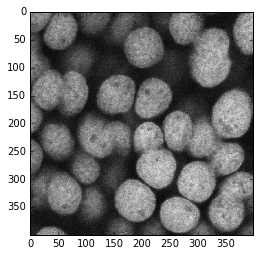

In [49]:
plt.imshow(im2)

In [142]:
go = GenerateImagesWithObjects(obj_size_range=(5,15))

In [143]:
x = np.expand_dims(go.generate_image(1), 0)

In [144]:
x.shape

(1, 400, 400, 3)

In [145]:
model.predict(x)

array([[ 2.04513907]], dtype=float32)

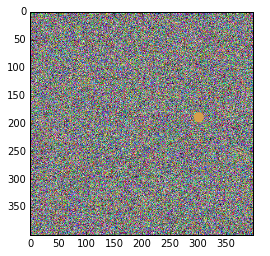

In [73]:
plt.imshow(x[0])